

# Workshop de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es, una vez limpiado el dataset, estudiarlo para extraer el máximo número de insights de los datos.



## Cargar librerias


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [117]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [119]:
DATAPATH = os.path.join('content', 'drive', 'My Drive', 'Data') 
filepath = os.path.join(DATAPATH, 'bank-full.csv')
print(filepath)

content/drive/My Drive/Data/bank-full.csv


In [0]:
from pyspark.sql import functions as F

## Lectura de datos

In [121]:
bank = spark.read.csv('file:///' + filepath, sep=';', header=True, inferSchema=True)
bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|  y|picked_up_call|extra_info|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---+--------------+----------+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown| no|             1|         1|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown| no|             1|         1|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown| no|             1|         1|
| 47| blue-collar| married| 

In [122]:
#Estudiamos las dimensiones

#Guardamos el número de registros
regist=bank.count()

#Guardamos el número de columnas
columnas=len(bank.columns)

(regist,columnas)

(45211, 20)

In [123]:
#Observamos el tipo de las variables
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



## Data Wrangling

### Cambiar los nombres de las columnas para que cumplan buenas prácticas

In [0]:
#Observamos que a priori los nombres de las columnas cumplen con las buenas prácticas, no obstante realizamos la instrucción
for col in bank.columns:
    bank = bank.withColumnRenamed(col, col.lower().replace(' ','_').replace('.',''))

In [125]:
#Vemos que la variable a predecir está nombrada como "y", no es un nombre descriptivo, por lo que lo modificamos a suscribed
bank=bank.withColumnRenamed('y', 'suscribed')
bank.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|       no|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|       no|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown|       no|             1|         1

### Estudiar el formato de las variables, ver cuáles se deberían modificar y modificarlas cuando se considere oportuno

In [126]:
#Revisamos los tipos de columna para ver si alguna podemos convertirla a un tipo más adecuado para el análisis
bank.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- suscribed: string (nullable = true)
 |-- picked_up_call: integer (nullable = true)
 |-- extra_info: integer (nullable = true)



In [127]:
#Cambiamos la variable a predecir a un valor binario para poder usarla en la matriz de correlación

bank=bank.withColumn('suscribed', F.when(F.col('suscribed') == 'yes', 1).otherwise(0))
bank.show(5)

+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+
| 58|  management|married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|        0|             1|         1|
| 44|  technician| single|secondary|     no|     29|    yes|  no|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|        0|             1|         1|
| 33|entrepreneur|married|secondary|     no|      2|    yes| yes|unknown|  5|  may|2008|      76|       1|   -1|       0| unknown|        0|             1|         1

### Estudiar si hay registros repetidos

In [128]:
#Vemos si hay registros duplicados. Borramos los duplicados y contamos para ver si se ha eliminado algún registro
bank_nodup = bank.dropDuplicates()
bank_nodup.count()

45211

In [129]:
if bank_nodup.count() == bank.count():
  print('No hay duplicados')
else:
  print('Se han eliminado' + (bank.count()-bank_nodup.count()) + 'duplicados')

No hay duplicados


###Transformación y creación de nuevas columnas para el análisis

In [0]:
#Separamos el conjunto bank en dos subconjuntos, uno de variables numéricas y otro de categóricas

quantitative_vars = [c for c,t in bank.dtypes if t in ['int', 'double']]
qualitative_vars = [c for c,t in bank.dtypes if t in ['boolean', 'string']]

In [131]:
#Creamos una lista con las variables cualitativas que tengan 2 valores
lista_bin = []
for col in qualitative_vars:
  if bank.select(col).distinct().count() == 2:
    lista_bin.append(col)
lista_bin

['default', 'housing', 'loan']

In [0]:
#Convertimos a binarias las variables default, housing y loan
for col in lista_bin:
  bank=bank.withColumn(col, F.when(F.col(col) == 'yes', 1).otherwise(0))

In [0]:
#Queremos convertir la variable marital en binaria, para ver posteriormente un posible impacto en la correlación de estado civil vs suscribed
#Diferenciamos entre 0: Soltero y 1:Casado o separado
bank=bank.withColumn('marital_bin', F.when(F.col('marital') == 'single', 0).otherwise(1))



In [0]:
#Agrupamos las edades por tramos
bank = bank.withColumn('tramo_edad', F.when(F.col('age') >= 60, 'Grupo4_mas_de_60').when(F.col('age') >= 40, 'Grupo3_entre_40_y_60').when(F.col('age') >= 20, 'Grupo2_entre_20_y_40').otherwise('Grupo1_menos_de_20'))


In [0]:
#Casteamos la columna extra_info a tipo String
bank = bank.withColumn('extra_info', F.col('extra_info').cast('string'))

In [136]:
#Creamos una columna (pyears) que sea el número de años desde el último contacto telefónico
#pyears toma el valor 0 para los valores de pdays=-1 y para el resto toma la parte entera +1 de pdays / 365
bank=bank.withColumn('pyears', F.when(F.col('pdays').isNull(), 0).otherwise((F.col('pdays')/365)+1).cast('int'))
bank.show(5)


+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+
|age|         job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|marital_bin|          tramo_edad|pyears|
+---+------------+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+
| 58|  management|married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|        0|             1|         1|          1|Grupo3_entre_40_y_60|     0|
| 44|  technician| single|secondary|      0|     29|      1|   0|unknown|  5|  may|2008|     151|       1|   -1|       0| unknown|        0|             1|         1|      

In [137]:
#COLUMNA AÑADIDA TRAS EL ANÁLISIS DE LOS GRÁFICOS

#Hemos observado que ciertas categorías con características similares tienen un comportamiento similar a la hora de contratar un producto. Es por ello que en una nueva columna
#vamos a agrupar los trabajos entre asalariados y no asalariados
bank.groupBy('job').count().show()

+-------------+-----+
|          job|count|
+-------------+-----+
|   management| 9458|
|      retired| 2264|
|      unknown|  288|
|self-employed| 1579|
|      student|  938|
|  blue-collar| 9732|
| entrepreneur| 1487|
|       admin.| 5171|
|   technician| 7597|
|     services| 4154|
|    housemaid| 1240|
|   unemployed| 1303|
+-------------+-----+



In [0]:
no_asalariados = ['retired','housemaid','student','unemployed']
asalariados = ['management','self-employed','blue-collar','entrepreneur','admin.','technician','services']

In [139]:
#Creamos una columna que sea el número de años desde que ha sido el último contacto
bank=bank.withColumn('asalariado', F.when((F.col('job').isin(asalariados)), 1).otherwise(0))
bank.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|marital_bin|          tramo_edad|pyears|asalariado|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+----------+
| 58|  management| married| tertiary|      0|   2143|      1|   0|unknown|  5|  may|2008|     261|       1|   -1|       0| unknown|        0|             1|         1|          1|Grupo3_entre_40_y_60|     0|         1|
| 44|  technician|  single|secondary|      0|     29|      1|   0|unknown|  5|  may|2008|     151|       1|   -1|       0| u

In [140]:
#Verificamos que los tipos del dataset son los mismo que los originales salvo el de suscribed (no hemos alterado el de pdays)
bank.dtypes


[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('default', 'int'),
 ('balance', 'int'),
 ('housing', 'int'),
 ('loan', 'int'),
 ('contact', 'string'),
 ('day', 'int'),
 ('month', 'string'),
 ('year', 'int'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('suscribed', 'int'),
 ('picked_up_call', 'int'),
 ('extra_info', 'string'),
 ('marital_bin', 'int'),
 ('tramo_edad', 'string'),
 ('pyears', 'int'),
 ('asalariado', 'int')]


### Estudiar si hay variables que siempre o prácticamente siempre toman el mismo valor: tomar siempre el mismo valor no aporta información al modelo

In [141]:
#Calculamos los valores distintos por variable
for col in bank.columns:
  countvalues = bank.select(col).distinct().count() 
  print(col, countvalues)

#Como no hay variables que tomen solo un valor en toda la columna, no podemos eliminar directamente ninguna  

age 77
job 12
marital 3
education 4
default 2
balance 7168
housing 2
loan 2
contact 3
day 31
month 12
year 3
duration 1573
campaign 48
pdays 559
previous 41
poutcome 4
suscribed 2
picked_up_call 2
extra_info 3
marital_bin 2
tramo_edad 4
pyears 4
asalariado 2


In [142]:
#Queremos ver el porcentaje de veces que aparece un valor, en caso de ser representativo, lo consideraremos para eliminar las variables
for x in bank.columns:
  print(x, "-----", bank.groupBy(x).count().sort(F.col('count').desc()).first()[0], "-----", (bank.groupBy(x).count().sort(F.col('count').desc()).first()[1])/bank.count()*100)

age ----- 32 ----- 4.611709539713787
job ----- blue-collar ----- 21.525734887527374
marital ----- married ----- 60.193315785981284
education ----- secondary ----- 51.3193691800668
default ----- 0 ----- 98.19734135497998
balance ----- 0 ----- 7.772444759018823
housing ----- 1 ----- 55.583818097365686
loan ----- 0 ----- 83.9773506447546
contact ----- cellular ----- 64.77405941032049
day ----- 20 ----- 6.087014222202561
month ----- may ----- 30.44834221760191
year ----- 2008 ----- 61.33241910154609
duration ----- 124 ----- 0.4158280064586052
campaign ----- 1 ----- 38.80471566654133
pdays ----- -1 ----- 81.73674548229414
previous ----- 0 ----- 81.73674548229414
poutcome ----- unknown ----- 81.74780473778506
suscribed ----- 0 ----- 88.30151954170445
picked_up_call ----- 1 ----- 99.99336444670544
extra_info ----- None ----- 99.82747561434164
marital_bin ----- 1 ----- 71.71042445422574
tramo_edad ----- Grupo2_entre_20_y_40 ----- 51.569308354161606
pyears ----- 0 ----- 81.73674548229414
asalar

Hay tres columnas que tienen un valor repetido más de un 98% de las veces. Hemos decidido no eliminarlas porque pueden tener información interesante:



*  Default: Contiene información sobre si un cliente está al corriente de pago (la mayoría lo están)
*  Picked_up_call: Nos indica si un cliente ha cogido el teléfono (la mayoría han cogido el teléfono)
*  Extra_info: Son observaciones sobre los clientes que pueden ser interesantes



### Estudiar los nulos en el dataset

In [0]:
#Al ver que pdays toma el mismo valor un alto porcentaje de veces, y viendo la descripción, consideramos que -1 equivale a null
bank = bank.withColumn('pdays', F.when(F.col("pdays") == -1, F.lit(None)).otherwise(F.col('pdays')))

In [144]:
#Cambiamos los unknown por null para poder contarlos después

for x in bank.columns:
  bank=bank.withColumn(x, F.when(F.col(x) == 'unknown', F.lit(None)).otherwise(F.col(x)))

bank.show()

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+----------+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|marital_bin|          tramo_edad|pyears|asalariado|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+--------------------+------+----------+
| 58|  management| married| tertiary|      0|   2143|      1|   0|   null|  5|  may|2008|     261|       1| null|       0|    null|        0|             1|         1|          1|Grupo3_entre_40_y_60|     0|         1|
| 44|  technician|  single|secondary|      0|     29|      1|   0|   null|  5|  may|2008|     151|       1| null|       0|  

In [145]:
#Vemos el porcentaje de nulos en cada columna
n_rows_bank = bank.count()

missing_ops = [F.round(F.sum(F.col(c).isNull().cast('int')) * 100 / n_rows_bank, 2).alias(c) 
               for c in bank.columns]

bank.select(missing_ops).show()

+---+----+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+
|age| job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|marital_bin|tramo_edad|pyears|asalariado|
+---+----+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+
|0.0|0.64|    0.0|     4.11|    0.0|    0.0|    0.0| 0.0|   28.8|0.0|  0.0| 0.0|     0.0|     0.0|81.74|     0.0|   81.75|      0.0|           0.0|     99.83|        0.0|       0.0|   0.0|       0.0|
+---+----+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+


In [146]:
#Vemos el número de nulos en cada columna

missing_ops2 = [F.sum(F.col(c).isNull().cast('int')).alias(c) 
               for c in bank.columns]

bank.select(missing_ops2).show()

+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+
|age|job|marital|education|default|balance|housing|loan|contact|day|month|year|duration|campaign|pdays|previous|poutcome|suscribed|picked_up_call|extra_info|marital_bin|tramo_edad|pyears|asalariado|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+
|  0|288|      0|     1857|      0|      0|      0|   0|  13020|  0|    0|   0|       0|       0|36954|       0|   36959|        0|             0|     45133|          0|         0|     0|         0|
+---+---+-------+---------+-------+-------+-------+----+-------+---+-----+----+--------+--------+-----+--------+--------+---------+--------------+----------+-----------+----------+------+----------+



## Análisis exploratorio de datos

### Análisis Univariante

In [0]:
#Al haber modificado los types de las variables, actualizamos las mismas

quantitative_vars = [c for c,t in bank.dtypes if t in ['int', 'double']]
qualitative_vars = [c for c,t in bank.dtypes if t in ['boolean', 'string']]

In [148]:
#Mostramos las variables cuantitativas
quantitative_vars

['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'year',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'suscribed',
 'picked_up_call',
 'marital_bin',
 'pyears',
 'asalariado']

In [149]:
#Mostramos las variables cualitativas
qualitative_vars

['job',
 'marital',
 'education',
 'contact',
 'month',
 'poutcome',
 'extra_info',
 'tramo_edad']

In [150]:
#Operaciones sobre las variables cuantitativas y calculamos sus principales estadísticos

avgs = [F.avg(col).alias('avg_' + col) for col in quantitative_vars]
maxs = [F.max(col).alias('max_' + col) for col in quantitative_vars]
mins = [F.min(col).alias('min_' + col) for col in quantitative_vars]
stds = [F.stddev(col).alias('std_' + col) for col in quantitative_vars]

operations = avgs + stds + maxs + mins 
results = bank.select(operations).first()

for col in quantitative_vars:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

age: avg=40.94, std=10.62, min=18, max=95
default: avg=0.02, std=0.13, min=0, max=1
balance: avg=1362.27, std=3044.77, min=-8019, max=102127
housing: avg=0.56, std=0.5, min=0, max=1
loan: avg=0.16, std=0.37, min=0, max=1
day: avg=15.81, std=8.32, min=1, max=31
year: avg=2008.44, std=0.6, min=2008, max=2010
duration: avg=258.16, std=257.53, min=0, max=4918
campaign: avg=2.76, std=3.1, min=1, max=63
pdays: avg=224.58, std=115.34, min=1, max=871
previous: avg=0.58, std=2.3, min=0, max=275
suscribed: avg=0.12, std=0.32, min=0, max=1
picked_up_call: avg=1.0, std=0.01, min=0, max=1
marital_bin: avg=0.72, std=0.45, min=0, max=1
pyears: avg=0.2, std=0.44, min=0, max=3
asalariado: avg=0.87, std=0.34, min=0, max=1


In [0]:
#Para las variables cualitativas como lo más representativo son tablas de frecuencia, ya lo hemos calculado anteriormente al estudiar los repetidos

### Análisis Multivariante

In [0]:
#Importamos librerías para realizar el análisis

from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [153]:
#Obtenemos la matriz de correlación, hay que tener en cuenta que a cada objeto, la función le hace un
#cast y lo convierte a un vector denso, me devuelve un Numpy array

corr_vars=['age',
 'default',
 'balance',
 'housing',
 'loan',
 'day',
 'year',
 'duration',
 'campaign',
 'previous',
 'suscribed',
 'picked_up_call',
 'marital_bin',
 'pyears',
 'asalariado']

corr_matrix = Statistics.corr(bank.select(corr_vars).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix



array([[ 1.00000000e+00, -1.78793036e-02,  9.77827394e-02,
        -1.85513082e-01, -1.56552727e-02, -9.12004563e-03,
        -8.02165059e-03, -4.64842847e-03,  4.76031176e-03,
         1.28831920e-03,  2.51550171e-02, -1.10448447e-02,
         4.27816608e-01, -1.18251355e-03, -2.57803897e-01],
       [-1.78793036e-02,  1.00000000e+00, -6.67450571e-02,
        -6.02521836e-03,  7.72342411e-02,  9.42389910e-03,
        -5.88883088e-02, -1.00214613e-02,  1.68215314e-02,
        -1.83294048e-02, -2.24189659e-02,  1.10372242e-03,
        -3.11519520e-03, -3.82265662e-02,  1.25909055e-02],
       [ 9.77827394e-02, -6.67450571e-02,  1.00000000e+00,
        -6.87683157e-02, -8.43502457e-02,  4.50258513e-03,
         3.14993258e-02,  2.15603805e-02, -1.45782789e-02,
         1.66736367e-02,  5.28384103e-02, -4.69743855e-03,
         1.25370015e-02,  2.51178048e-02, -3.83577852e-02],
       [-1.85513082e-01, -6.02521836e-03, -6.87683157e-02,
         1.00000000e+00,  4.13228660e-02, -2.79816493

In [0]:
#Transformamos la matriz en una de Pandas
corr_matrix = pd.DataFrame(corr_matrix, columns=corr_vars, index=corr_vars)

In [0]:
%matplotlib inline

In [0]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

In [157]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix

,age,default,balance,housing,loan,day,year,duration,campaign,previous,suscribed,picked_up_call,marital_bin,pyears,asalariado
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,-0.017879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,0.097783,-0.066745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,-0.185513,-0.006025,-0.068768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,-0.015655,0.077234,-0.084350,0.041323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day,-0.009120,0.009424,0.004503,-0.027982,0.011370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,-0.008022,-0.058888,0.031499,-0.072606,-0.100893,-0.170216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration,-0.004648,-0.010021,0.021560,0.005075,-0.012412,-0.030206,0.037030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
campaign,0.004760,0.016822,-0.014578,-0.023599,0.009980,0.162490,-0.166185,-0.084570,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous,0.001288,-0.018329,0.016674,0.037076,-0.011043,-0.051710,0.293186,0.001203,-0.032855,NaN,NaN,NaN,NaN,NaN,NaN


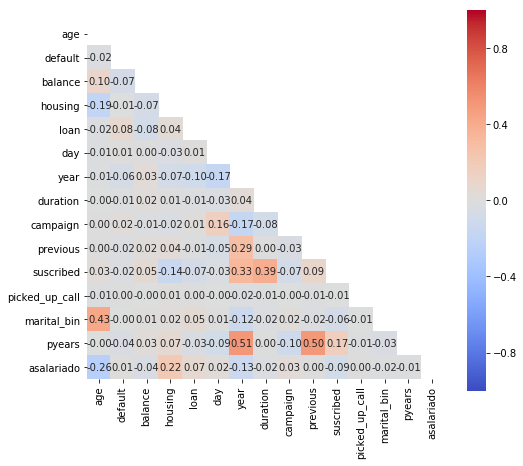

In [158]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')

### Detección de outliers
Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey. Éste dice que se considera valor atípico a todo aquel que **esté fuera** del siguiente rango:

- Valor atípico: $ Q_1 - 1.5\cdot IQR > x > Q_3 + 1.5 \cdot IQR$
- Valor atípico extremo: $Q_1 - 3\cdot IQR > x >Q_3 + 3\cdot IQR$

Vamos a crear una función para identifucar outliers usando el test de Tukey.

In [0]:
#Vemos los valores atípicos

def remove_tukey_outliers(df, col):
  """
  Returns a new dataframe with outliers removed on column 'col' usting Tukey test
  """
  q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
  IQR = q3 - q1
   
  min_thresh = q1 - 1.5 * IQR
  max_thresh = q3 + 1.5 * IQR
   
  df_no_outliers = df.filter((F.col(col).between(min_thresh, max_thresh)) & (F.col(col).isNotNull()))
   
  return df_no_outliers

In [160]:
for x in quantitative_vars:
  sinout = remove_tukey_outliers(bank, x)
  print(x, bank.count() - sinout.count())

age 381
default 815
balance 4872
housing 0
loan 7244
day 0
year 0
duration 3334
campaign 3064
pdays 37005
previous 8257
suscribed 5289
picked_up_call 3
marital_bin 0
pyears 8257
asalariado 6033


In [0]:
#Vemos los valores extremos

def remove_tukey_outliers_ext(df, col):
  """
  Returns a new dataframe with outliers removed on column 'col' usting Tukey test
  """
  q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
  IQR = q3 - q1
   
  min_thresh = q1 - 3 * IQR
  max_thresh = q3 + 3 * IQR
   
  df_no_outliers = df.filter((F.col(col).between(min_thresh, max_thresh)) & (F.col(col).isNotNull()))
   
  return df_no_outliers

In [162]:
for x in quantitative_vars:
  sinout = remove_tukey_outliers_ext(bank, x)
  print(x, bank.count() - sinout.count())

age 0
default 815
balance 2518
housing 0
loan 7244
day 0
year 0
duration 1194
campaign 1462
pdays 36954
previous 8257
suscribed 5289
picked_up_call 3
marital_bin 0
pyears 8257
asalariado 6033


In [0]:
#Eliminamos los outliers extremos de todas las variables numéricas excepto de pdays, ya que tiene un número elevado de outliers y nos quedaríamos sin muestra
sinout = bank
for x in corr_vars:
  sinout = remove_tukey_outliers_ext(sinout, x)

In [164]:
#Una vez eliminados contamos los registros
sinout.count()

21172

Tras eliminar los outliers extremos vemos que se eliminan casi el 50% de los registros (con pdays nos elimina el 90%). 

Por tanto, decidimos no eliminar ningún registro para el análisis.

### Test de hipótesis

In [165]:
sample_data = bank.sample(False, fraction=0.5).toPandas()
sample_data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,...,pdays,previous,poutcome,suscribed,picked_up_call,extra_info,marital_bin,tramo_edad,pyears,asalariado
0,35,management,married,tertiary,0,231,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo2_entre_20_y_40,0,1
1,42,entrepreneur,divorced,tertiary,1,2,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,1
2,58,retired,married,primary,0,121,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,0
3,43,technician,single,secondary,0,593,1,0,None,5,...,NaN,0,None,0,1,None,0,Grupo3_entre_40_y_60,0,1
4,29,admin.,single,secondary,0,390,1,0,None,5,...,NaN,0,None,0,1,None,0,Grupo2_entre_20_y_40,0,1
5,53,technician,married,secondary,0,6,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,1
6,58,technician,married,None,0,71,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,1
7,57,services,married,secondary,0,162,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,1
8,51,retired,married,primary,0,229,1,0,None,5,...,NaN,0,None,0,1,None,1,Grupo3_entre_40_y_60,0,0
9,45,admin.,single,None,0,13,1,0,None,5,...,NaN,0,None,0,1,None,0,Grupo3_entre_40_y_60,0,1


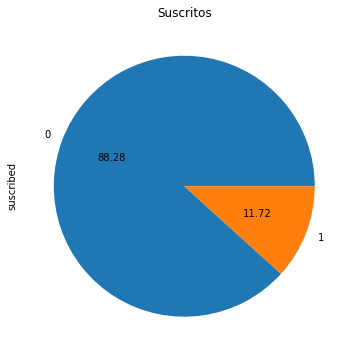

In [166]:
#Pintamos un gráfico de tarta para ver la distribución de la variable Suscribed
plot = sample_data['suscribed'].value_counts().plot(kind='pie', autopct='%.2f', 
                                            figsize=(6, 6),
                                            title='Suscritos')

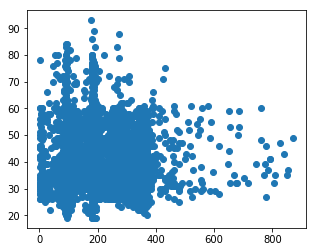

In [167]:
#Distribución entre la edad y el número de días que pasan desde la anterior llamada
plt.figure(figsize=(5,4))
plt.scatter(sample_data['pdays'], sample_data['age'])

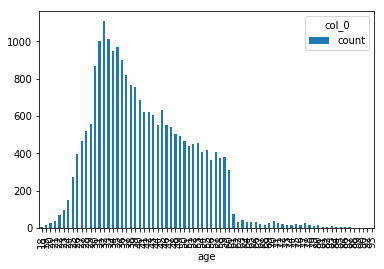

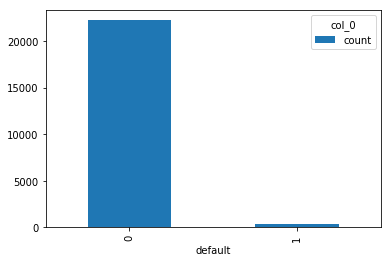

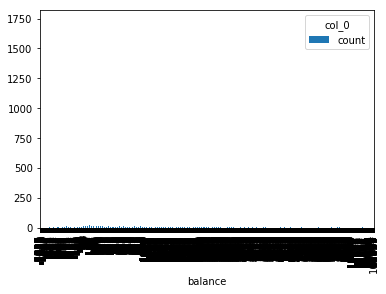

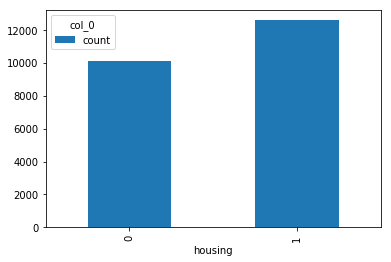

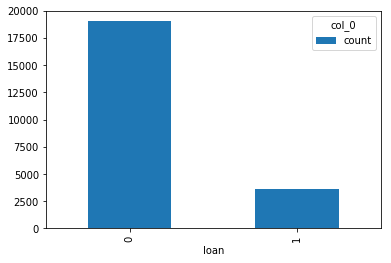

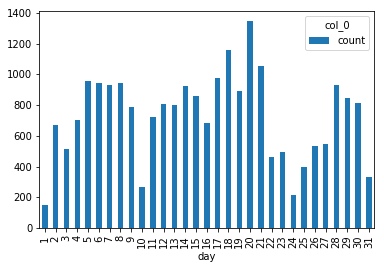

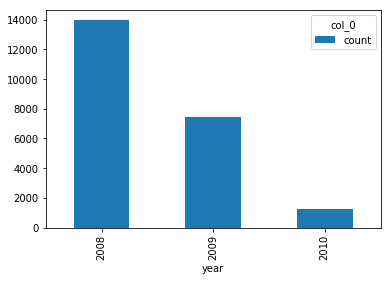

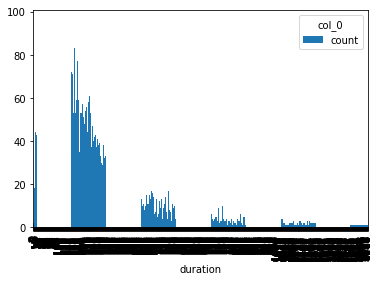

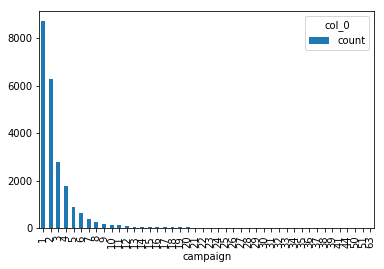

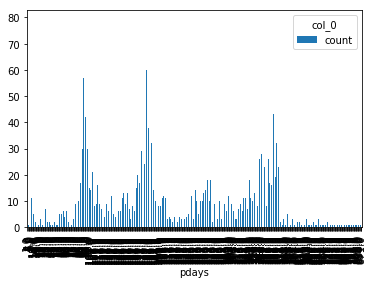

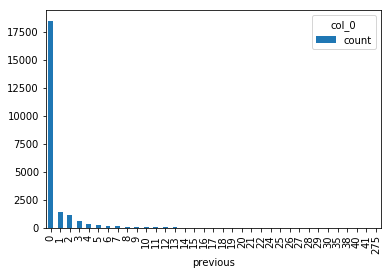

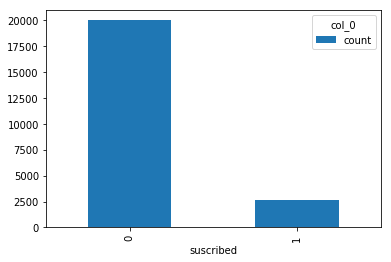

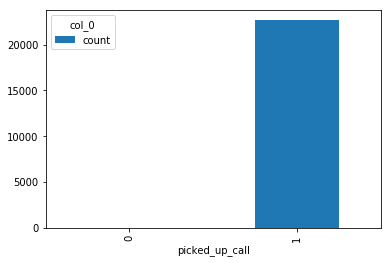

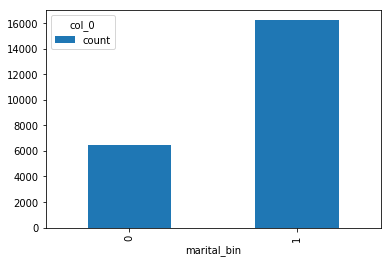

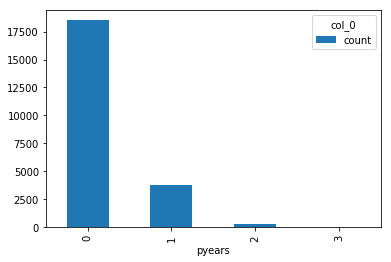

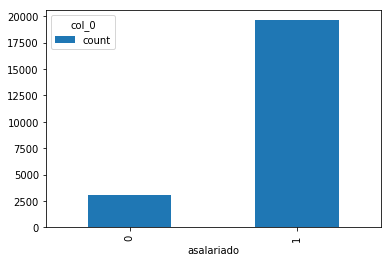

In [168]:
#Graficamos las variables cuantitativas
for x in quantitative_vars:
  my_table = pd.crosstab(index = sample_data[x],
                             columns="count")

  my_table.plot.bar()

Conclusiones:
  
*  Están llamando a gente joven
* La mayoría de la gente están al corriente de pago
* 2008 fue el año que más llamadas hubo
* La mayoría de personas son contactadas de 1 a 2 veces por campaña, por lo que suele ser antes de que cumpla un año (última gráfica)
* Contactan más a casados o divorciados




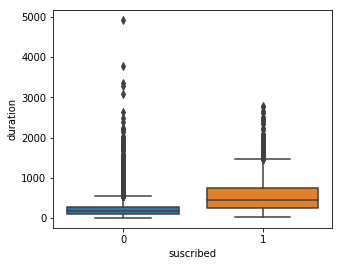

In [169]:
#BOXPLOT
plt.figure(figsize=(5,4))
sns.boxplot(x='suscribed', y='duration', data=sample_data, orient='v')

**Como vemos,cuanto mayor es la duración de la llamada, más probabilidades hay de suscribirse,  es la correlación más significativa**

**Cuando un cliente no tienen interés en contratar el producto corta rápido la llamada**

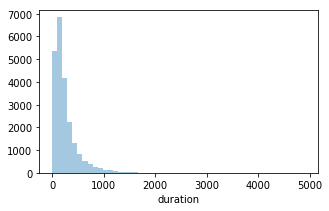

In [170]:
plt.figure(figsize=(5,3))
sns.distplot(sample_data['duration'], kde=False)

**La mayoría de las llamadas tienen una duración corta**

Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

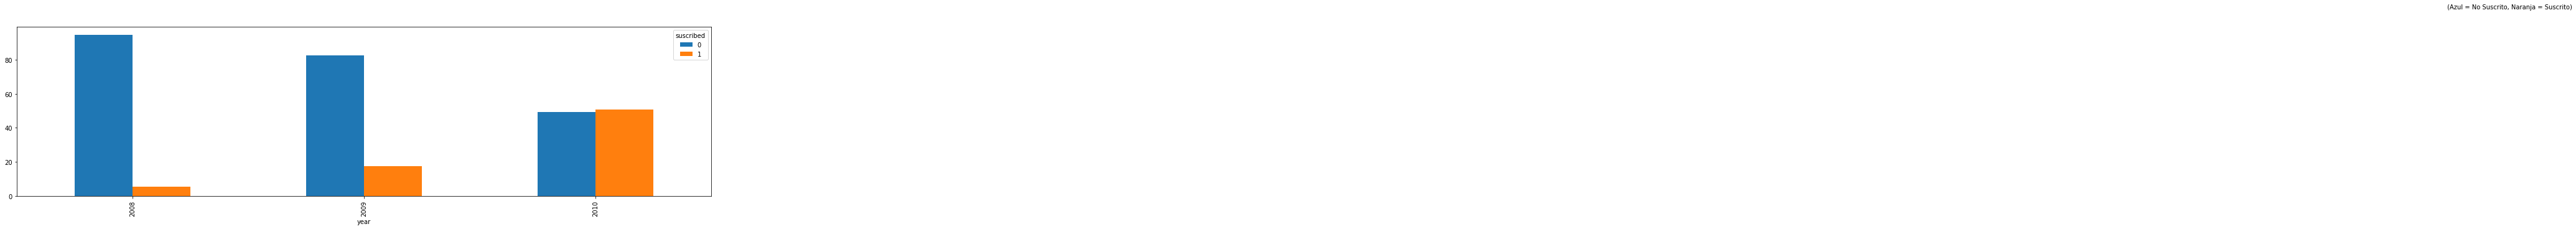

In [171]:
plot = pd.crosstab(index=sample_data['year'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")

**El mayor porcentaje de las contrataciones se realizan en el año 2010 (puede ser debido al ciclo económico)**

Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

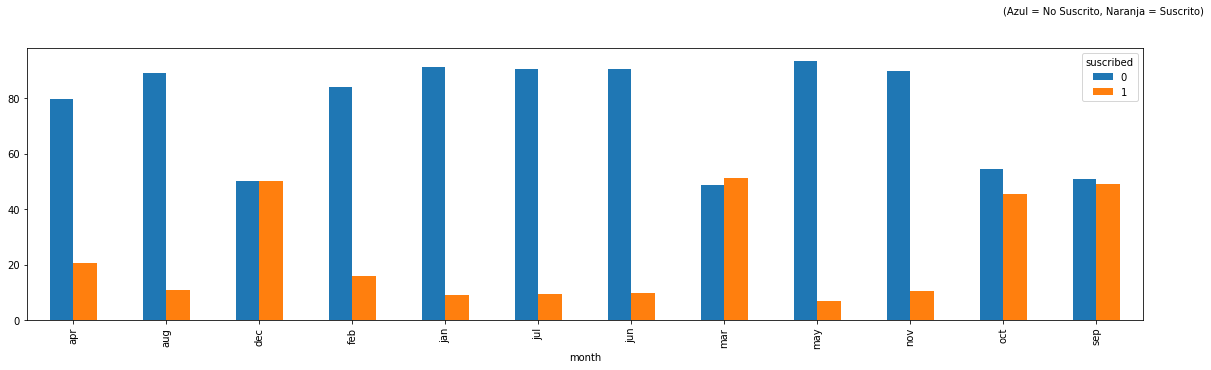

In [172]:
plot = pd.crosstab(index=sample_data['month'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")

**A partir del mes de agosto y hasta final de año aumenta la probabilidad de conseguir que el cliente contrate el producto**

Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

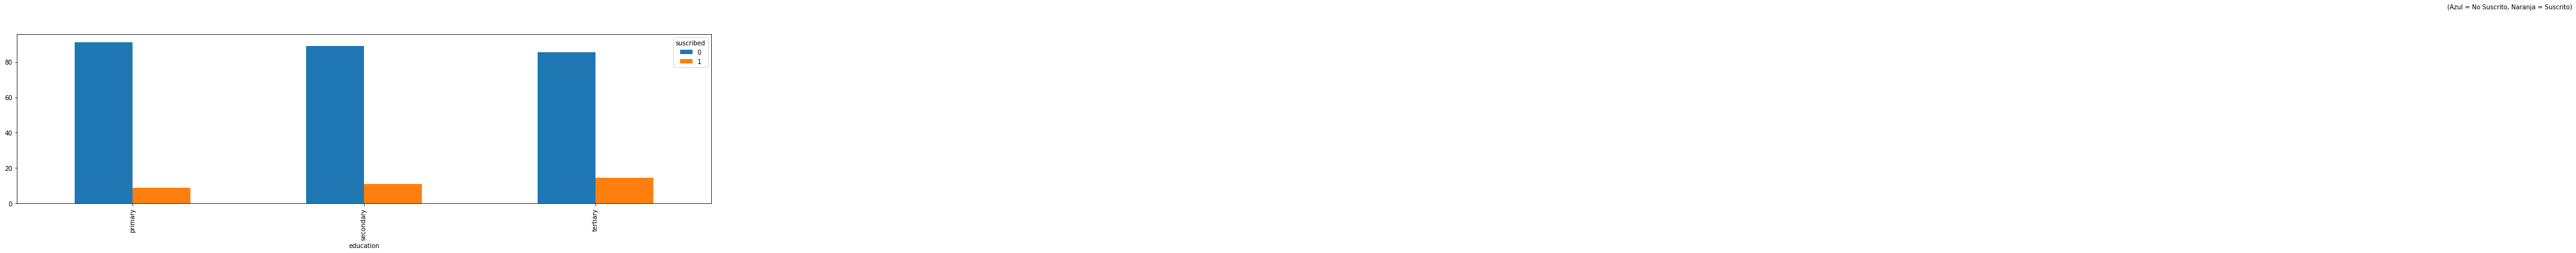

In [173]:
plot = pd.crosstab(index=sample_data['education'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")

**Al analizar las contrataciones por tipo de educación cursada, vemos que cuanto mayor es el nivel educativo mayor es la probabilidad de contratar un producto**

Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

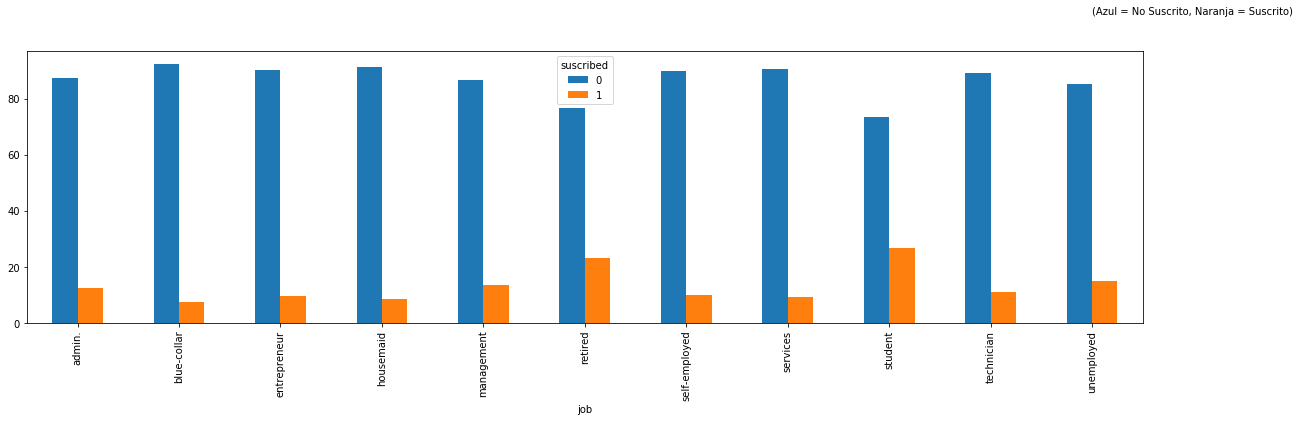

In [174]:
plot = pd.crosstab(index=sample_data['job'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")

**Analizamos la contratación según el trabajo de cada cliente**

Podemos ver que ciertas categorías tienen un porcentaje de contratación superior al 20%:


*   Retired
*   Student

Otra categoría como unemployed tiene un porcentaje alto de contratación, lo que nos ha motivado a agrupar estas 3 junto a housemaid en una nueva categoría que almacenamos en la columna asalariado

Esta columna asalariado será binaria y tendrá como valor 1 a clientes con salario y 0 a clientes que no tienen salario o tienen una pensión




Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

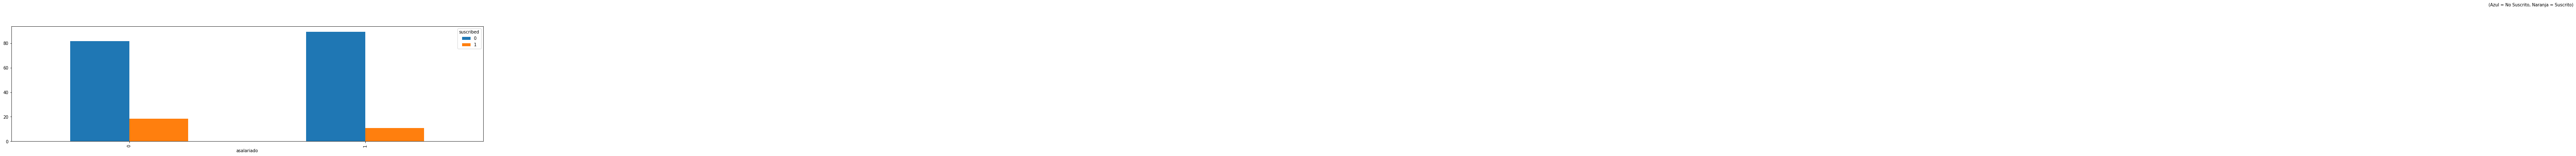

In [175]:
plot = pd.crosstab(index=sample_data['asalariado'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")

**Al hacer la agrupación por asalariado, vemos que la contratación es mayor en aquellos clientes que no tienen un salario (≈20% no asalariados vs. ≈10% asalariados)**

Text(10, 110, '(Azul = No Suscrito, Naranja = Suscrito)')

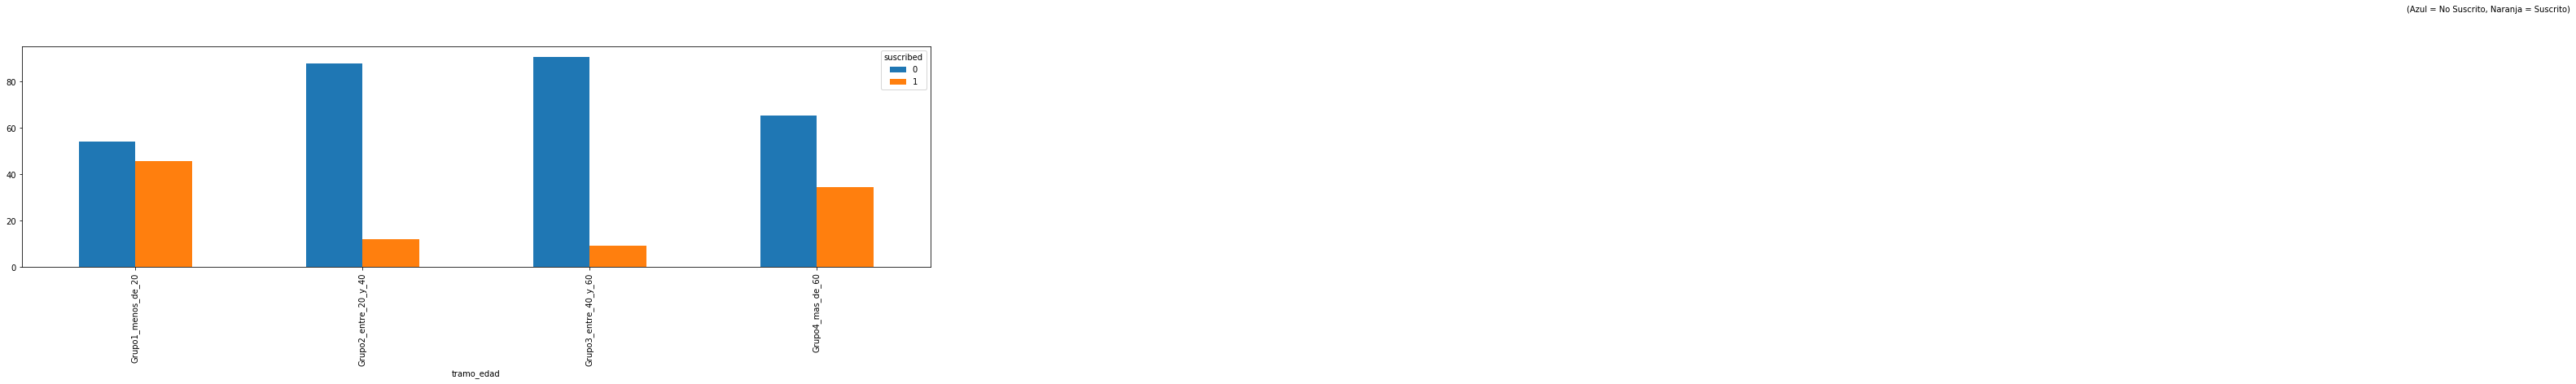

In [176]:
plot = pd.crosstab(index=sample_data['tramo_edad'],
            columns=sample_data['suscribed'],).apply(lambda r: r/r.sum() *100,
                                              axis=1).plot(kind='bar',figsize=(20,5))
plt.text(10,110,"(Azul = No Suscrito, Naranja = Suscrito)")


**Al analizar los datos por tramos de edad vemos que los clientes menores de 20 años (estudiantes) y los mayores de 60 años (jubilados) tienen un mayor porcentaje de contratación respecto al resto de colectivos.**